In [13]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from pathlib import Path
import datetime
import h5py
from astropy.visualization import astropy_mpl_style

from IPython import display
%matplotlib inline

In [14]:
# Hyperparameters of architecture and training
hyperparameters = {
    'LAT_DIM': 128,
    'BATCH_SIZE': 16,
    'EPOCHS': 50,
    'NUM_EXAMPLES_TO_GENERATE': 16,
}

# Run identifier
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Logging
LOG_DIR = Path(os.environ['TF_LOGDIR']) / current_time
summary_writer = tf.summary.create_file_writer(str(LOG_DIR.absolute()))

In [15]:
print("Run ID: ", current_time)
print("Logging in: ", LOG_DIR.absolute())

Run ID:  20191211-122920
Logging in:  /oasis/scratch/comet/bthorne/temp_project/logs/20191211-122920


In [16]:
# Batch and shuffle the data
RES = 256
STEP_SIZE = 4
GAL_CUT = 16
record_dir = Path("../data/preprocessed/")
fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))

train_images = np.load(fpath).astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(hyperparameters['BATCH_SIZE'])

test_dataset = dataset.take(100) 
train_dataset = dataset.skip(100)
print(hyperparameters)

{'LAT_DIM': 128, 'BATCH_SIZE': 16, 'EPOCHS': 50, 'NUM_EXAMPLES_TO_GENERATE': 16}


In [37]:
def make_vae_generative_net(latent_dim):
    model = tf.keras.Sequential(name='Decoder')
    
    model.add(tf.keras.layers.InputLayer(input_shape=(latent_dim,)))
    model.add(tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Reshape(target_shape=(16, 16, 32)))
    assert model.output_shape == (None, 16, 16, 32)
    
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu'))
    assert model.output_shape == (None, 32, 32, 128)
    
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu'))
    assert model.output_shape == (None, 64, 64, 128)
    
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu'))
    assert model.output_shape == (None, 128, 128, 128)
    
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu'))
    assert model.output_shape == (None, 256, 256, 128)
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=(1, 1), padding="SAME"))
    return model

def make_vae_inference_net(latent_dim):
    model = tf.keras.Sequential(name='Encoder')
    
    model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 1)))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 126, 126, 256)
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 61, 61, 128)
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 29, 29, 64)
    
    model.add(tf.keras.layers.Flatten())
    assert model.output_shape == (None, 29 * 29 * 64)
    
    model.add(tf.keras.layers.Dense(latent_dim + latent_dim))
    return model

In [38]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = make_vae_inference_net(latent_dim)

        self.generative_net = make_vae_generative_net(latent_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [36]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    cross_ent = tf.keras.losses.MSE(x, x_logit)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(16,16))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [11]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[hyperparameters['NUM_EXAMPLES_TO_GENERATE'], hyperparameters['LAT_DIM']])
optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAE(hyperparameters['LAT_DIM'])

Epoch: 29, Test set ELBO: -427.2730407714844, time elapse for current epoch 3.883437395095825


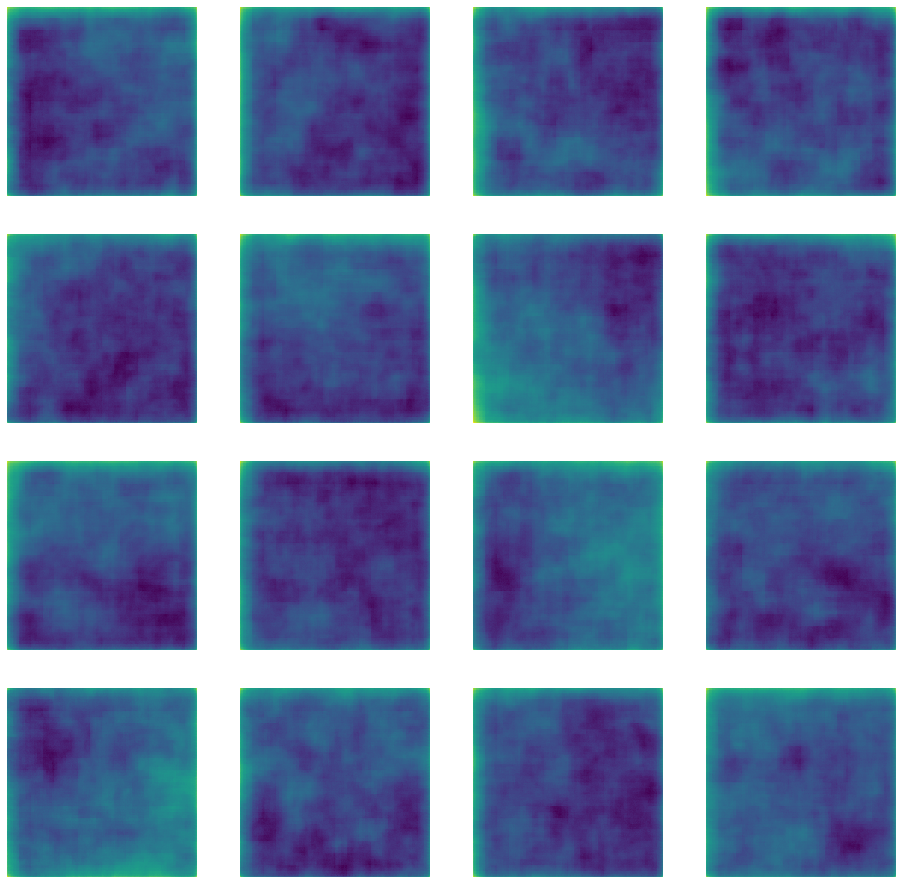

KeyboardInterrupt: 

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, hyperparameters['EPOCHS'] + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()



    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
          loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        with summary_writer.as_default():
            tf.summary.scalar('elbo', elbo, step=epoch)
        
        generate_and_save_images(
            model, epoch, random_vector_for_generation)

In [ ]:
encoded_training_data = np.array([np.array(model.encode(img)) for img in train_dataset])

In [ ]:
encoded_training_data = np.empty((1840, 50))
i = 0
for train_images in train_dataset:
    for img in train_images:
        encoded_training_data[i] = model.encode(img[None, ...])[1]
        i += 1

In [ ]:
plt.hist(encoded_training_data.flatten(), range=[-10, 5], bins=50)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1., 315., 739., 399., 152.,  82.,  36.,  33.,
         17.,  19.,  15.,  16.,  12.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-10. ,  -9.7,  -9.4,  -9.1,  -8.8,  -8.5,  -8.2,  -7.9,  -7.6,
         -7.3,  -7. ,  -6.7,  -6.4,  -6.1,  -5.8,  -5.5,  -5.2,  -4.9,
         -4.6,  -4.3,  -4. ,  -3.7,  -3.4,  -3.1,  -2.8,  -2.5,  -2.2,
         -1.9,  -1.6,  -1.3,  -1. ,  -0.7,  -0.4,  -0.1,   0.2,   0.5,
          0.8,   1.1,   1.4,   1.7,   2. ,   2.3,   2.6,   2.9,   3.2,
          3.5,   3.8,   4.1,   4.4,   4.7,   5. ]),
 <a list of 50 Patch objects>)

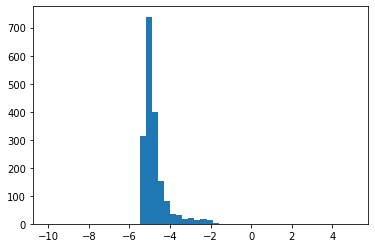

In [50]:
plt.hist(encoded_training_data[:, 49], range=[-10, 5], bins=50)

In [51]:
import pymaster as nmt

In [64]:
pred_maps = np.array(model.decode(np.random.randn(100, latent_dim)))
print(pred_maps.shape)

(100, 256, 256, 1)


In [77]:
xlen = 10
ylen = 10
xres = 256
yres = 256

In [78]:
Lx = 2 * xlen * np.pi/180
Ly = 2 * ylen * np.pi/180
Nx = xres
Ny = yres


In [79]:
mask = np.ones(Nx * Ny).reshape((Nx, Ny))
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

In [80]:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=1., apotype="C1")

In [81]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [pred_maps[0, :, :, 0]])
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, l0_bins)

In [82]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [83]:
def get_uncoupled_spectrum(wsp, field0, nmtbin):
    cl_coupled = nmt.compute_coupled_cell_flat(field0, field0, nmtbin)
    return wsp.decouple_cell(cl_coupled)

cl = np.empty((pred_maps.shape[0], b.get_n_bands()))
for i in range(pred_maps.shape[0]):
    field = nmt.NmtFieldFlat(Lx, Ly, mask, [pred_maps[i, :, :, 0]])
    cl[i] = get_uncoupled_spectrum(w00, field, b)
    #field_gen = nmt.NmtFieldFlat(Lx, Ly, mask, [gen_arr_exp[i, :, :, 0]])
    #cl_gen[i] = get_uncoupled_spectrum(w00, field_gen, b)

In [84]:
ells_uncoupled = b.get_effective_ells()

(1e-11, 1e-07)

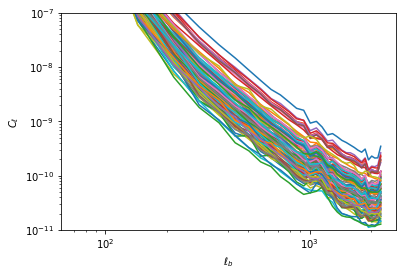

In [87]:
fig, ax = plt.subplots(1, 1)
for i in range(pred_maps.shape[0]):
    ax.loglog(ells_uncoupled, cl[i])
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$C_\ell$")
ax.set_ylim(1e-11, 1e-7)